Generating 512x512 fBm noise with 6 octaves...
Generation took: 0.3105 seconds


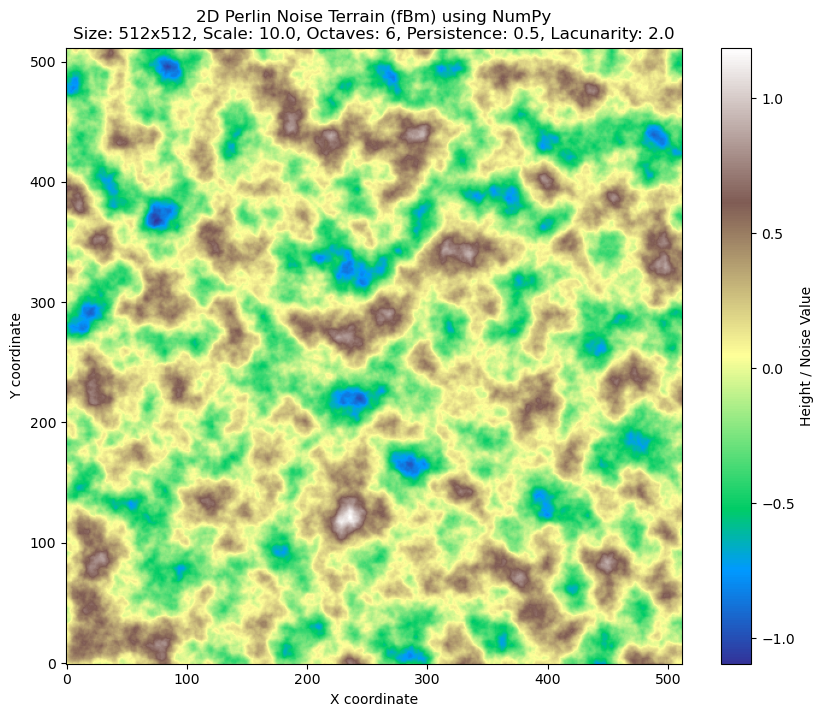

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time # Optional: To time the generation

# --- Perlin Noise Core Implementation ---

def fade(t):
  """Smootherstep fade function: 6t^5 - 15t^4 + 10t^3"""
  return 6 * t**5 - 15 * t**4 + 10 * t**3

def lerp(a, b, t):
  """Linear interpolation: a + t * (b - a)"""
  return a + t * (b - a)

def gradient(h, x, y):
  """
  Calculates the dot product between a randomly chosen gradient vector
  and the vector from the grid point to the sample point (x, y).
  'h' is a hash value used to select the gradient.
  """
  # Predefined gradient vectors (can use 8 or 12 for smoother results)
  vectors = np.array([[1,1],[-1,1],[1,-1],[-1,-1], # Diagonals
                      [1,0],[-1,0],[0,1],[0,-1]])  # Cardinal
  # Use hash 'h' (masked) to index into gradient table
  g = vectors[h & 7] # Mask with 7 (binary 111) for 8 vectors
  # Calculate dot product: g.x * x + g.y * y
  # NumPy handles element-wise multiplication and addition for arrays x, y
  return g[..., 0] * x + g[..., 1] * y

def perlin_noise_2d(x, y, permutation_table):
  """
  Calculates 2D Perlin noise for input coordinates x, y.
  x, y can be NumPy arrays (e.g., from meshgrid).
  permutation_table is the doubled permutation array (0-255 shuffled, then repeated).
  """
  # Determine grid cell coordinates (integer parts)
  Xi = x.astype(int)
  Yi = y.astype(int)

  # Determine internal cell coordinates (fractional parts)
  xf = x - Xi
  yf = y - Yi

  # Compute fade curves for internal coordinates
  u = fade(xf)
  v = fade(yf)

  # --- Hash coordinates of the 4 square corners ---
  # Modulo 256 to wrap around the permutation table indices
  p = permutation_table
  ii = Xi & 255
  ji = Yi & 255

  # Calculate hash values for the 4 corners using the permutation table
  # p[ii] gives a hash based on x-index
  # p[p[ii] + ji] combines x and y index hashes
  h00 = p[p[ii] + ji]
  h10 = p[p[ii + 1] + ji] # Corner (x+1, y)
  h01 = p[p[ii] + ji + 1] # Corner (x, y+1)
  h11 = p[p[ii + 1] + ji + 1] # Corner (x+1, y+1)

  # --- Calculate gradients (dot products) ---
  # xf, yf are vectors from the grid points to the sample point
  # For corner (1,0), the vector is (xf-1, yf), etc.
  g00 = gradient(h00, xf,   yf)
  g10 = gradient(h10, xf-1, yf)
  g01 = gradient(h01, xf,   yf-1)
  g11 = gradient(h11, xf-1, yf-1)

  # --- Interpolate ---
  # Interpolate along x-axis
  x1 = lerp(g00, g10, u)
  x2 = lerp(g01, g11, u)
  # Interpolate along y-axis
  return lerp(x1, x2, v)


# --- Fractional Brownian Motion (fBm) ---

def fBm(x, y, permutation_table, octaves=6, persistence=0.5, lacunarity=2.0, initial_amplitude=1.0, initial_frequency=1.0):
  """
  Generates fBm noise by summing multiple 'octaves' of Perlin noise
  with decreasing amplitude (persistence) and increasing frequency (lacunarity).
  """
  total_noise = np.zeros(x.shape)
  amplitude = initial_amplitude
  frequency = initial_frequency

  for i in range(octaves):
    total_noise += amplitude * perlin_noise_2d(x * frequency, y * frequency, permutation_table)

    amplitude *= persistence # Decrease amplitude for next octave
    frequency *= lacunarity # Increase frequency for next octave

  return total_noise

# --- Main Generation ---

# Parameters
width = 512
height = 512
scale = 10.0 # Controls the zoom level of the noise pattern
octaves = 6      # Number of noise layers
persistence = 0.5 # Amplitude decrease per octave
lacunarity = 2.0  # Frequency increase per octave
seed = None # Set to an integer for reproducible results, None for random

# 1. Create Permutation Table (shuffled 0-255, duplicated)
if seed is not None:
    np.random.seed(seed)
perm = np.arange(256, dtype=int)
np.random.shuffle(perm)
p_table = np.concatenate((perm, perm)) # Double the table

# 2. Create Coordinate Grid
# Create arrays of x and y coordinates, scaled appropriately
lin_x = np.linspace(0, 1, width, endpoint=False)
lin_y = np.linspace(0, 1, height, endpoint=False)
x, y = np.meshgrid(lin_x, lin_y) # Create 2D coordinate grid

# Apply scale
scaled_x = x * scale
scaled_y = y * scale

# 3. Generate Noise
print(f"Generating {width}x{height} fBm noise with {octaves} octaves...")
start_time = time.time()
noise_map = fBm(scaled_x, scaled_y, p_table, octaves, persistence, lacunarity)
end_time = time.time()
print(f"Generation took: {end_time - start_time:.4f} seconds")

# Optional: Normalize noise map to [0, 1] range for visualization
# noise_map = (noise_map - np.min(noise_map)) / (np.max(noise_map) - np.min(noise_map))

# 4. Visualize using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(noise_map, cmap='terrain', origin='lower') # 'gray', 'viridis', 'plasma', 'terrain' are good colormaps
plt.colorbar(label='Height / Noise Value')
plt.title(f'2D Perlin Noise Terrain (fBm) using NumPy\n'
          f'Size: {width}x{height}, Scale: {scale}, Octaves: {octaves}, '
          f'Persistence: {persistence}, Lacunarity: {lacunarity}')
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.show()